# 1. Import libraries for Recommendation system and plotting

For the recommendation engine this notebook uses the standard Keras deep learning model. https://keras.io/api/models/model/

In [2]:
# Import Libraries
import os
from IPython.display import Image
from IPython.display import SVG
import pydot
import statistics

# standard
import numpy as np
import pandas as pd
import pandas_profiling
import random

# spicy
from scipy.sparse import csr_matrix

# tensorflow & keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import Concatenate, Dense, Dropout

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# data visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


# 2. Import and analyze the data

This section of the notebook imports various movie data, user data, and movie rating data.

In [3]:
# Import core data
tags = pd.read_csv('data/genome-tags.csv')
movies = pd.read_csv('data/movies.csv')
user_tags = pd.read_csv('data/tags.csv')
tag_scores = pd.read_csv('data/genome-scores.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')

count    2.838583e+06
mean     3.540060e+00
std      1.060301e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


(array([ 44129.,  87276.,  45705., 185480., 141961., 551398., 359561.,
        757718., 250621., 414734.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

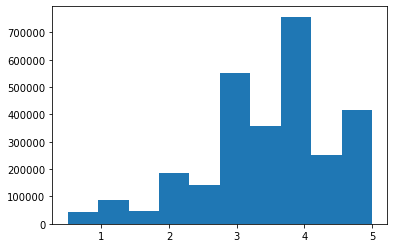

In [4]:
# View the ratings summary statiscis
print(ratings.rating.describe())

# Plot the movie ratings
plt.hist(ratings.rating)

# 3. Prepare feature vectors and train the Keras model

This section of the notebook containts the code to vectorize user, movie, and rating data in order to train a Keras model

In [5]:
# Get user and movie vectors
users_from_ratings = ratings.userId.unique()
movies_from_ratings = ratings.movieId.unique()

# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

# Create vector of ordered users in case we are missing a userId
user_map = {i:val for i,val in enumerate(users_from_ratings)}
inverse_user_map = {val:i for i,val in enumerate(users_from_ratings)}

# Create vector of ordered movies in case we are missing a moveId
movie_map = {i:val for i,val in enumerate(movies_from_ratings)}
inverse_movie_map = {val:i for i,val in enumerate(movies_from_ratings)}

# Add the ordered userIds and movieIds back to the Ratings data frame
ratings["new_user_id"] = ratings["userId"].map(inverse_user_map)
ratings["new_movie_id"] = ratings["movieId"].map(inverse_movie_map)

In [7]:
# Display rating data for original userId 9171, this is the user for comparing model results for the project
ratings[ratings["userId"] == 9171]

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
1361922,9171,32,4.5,1.546725e+09,9170,251
1361923,9171,47,4.5,1.546361e+09,9170,924
1361924,9171,50,4.0,1.546361e+09,9170,252
1361925,9171,111,4.0,1.546361e+09,9170,253
1361926,9171,260,5.0,1.546361e+09,9170,76
...,...,...,...,...,...,...
1362082,9171,187593,4.5,1.546361e+09,9170,839
1362083,9171,189713,4.0,1.546812e+09,9170,6647
1362084,9171,192385,4.5,1.546363e+09,9170,6720
1362085,9171,192803,4.5,1.546725e+09,9170,3955


In [8]:
# create train and test datasets
new_ratings = ratings.sample(frac=1, random_state=42)

# Get the values for usersids and movieids
x = new_ratings[["new_user_id", "new_movie_id"]].values

# Normalize ratings between 0 and 1 to optimize training
y = new_ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split train and test data into 70/30
train_indices = int(0.7 * new_ratings.shape[0])
x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:],)


In [9]:
# Code below is guidance from Keras documentation on Recommendation engines. 
# I tried a number of permutations of the embedding sizes, intializers, and regularization but nothing seemed to perform any better. 

class RecommenderNet(keras.Model):
    """Model class for recommendation engine using Keras neural network"""
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer="he_normal", embeddings_regularizer=keras.regularizers.l2(1e-6),)
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(num_movies,embedding_size,embeddings_initializer="he_normal", embeddings_regularizer=keras.regularizers.l2(1e-6),)
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        """Constructor to help with initializing the recommendation engine"""
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)


In [10]:
# Compile the model
model = RecommenderNet(users_from_ratings.shape[0], movies_from_ratings.shape[0], 50)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['mse'])

In [24]:
# Train the Keras Recommender model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
31047/31047 [==============================] - 812s 26ms/step - loss: 0.0570 - mse: 0.0505 - val_loss: 0.0657 - val_mse: 0.0545
Epoch 2/5
31047/31047 [==============================] - 804s 26ms/step - loss: 0.0758 - mse: 0.0615 - val_loss: 0.0830 - val_mse: 0.0661
Epoch 3/5
31047/31047 [==============================] - 816s 26ms/step - loss: 0.0903 - mse: 0.0716 - val_loss: 0.0936 - val_mse: 0.0734
Epoch 4/5
31047/31047 [==============================] - 824s 27ms/step - loss: 0.0986 - mse: 0.0775 - val_loss: 0.0990 - val_mse: 0.0770
Epoch 5/5
31047/31047 [==============================] - 825s 27ms/step - loss: 0.1028 - mse: 0.0803 - val_loss: 0.1019 - val_mse: 0.0789


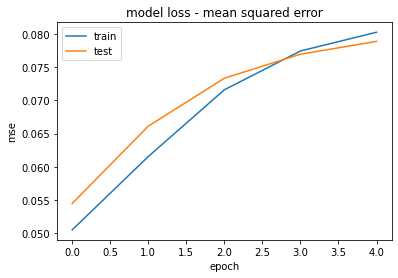

In [25]:
# Plot the model loss, MSE
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.title("model loss - mean squared error")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# 4. Create movie recommendations

This section of the notebook uses our trained Keras model plus collaborative filtering to generate 10 movie recommendations for a given user

In [26]:
# Create function to get top similar users
def get_top_similar_users(user_id, current_user, similar_user_ratings, similar_user_count):
    """This function takes a user id and user threshold to return the top similar users based upon movie ratings"""
    
    # Create dictionary to store userids and similarity scores
    similar_users = dict()
    
    # Get list of similiar user ids
    similar_user_ids = similar_user_ratings.index
    len_similar_users = len(similar_user_ids)

    # Calculate similarities for all users
    for i in range(len_similar_users):
        
        next_user_id = similar_user_ids[i]

        # Make sure we don't calculate similarity for current user
        if next_user_id != user_id:
            next_user = similar_user_ratings.loc[[next_user_id]].to_numpy()
            similar_users[i] = cosine_similarity(current_user,next_user)[0][0]
    
    # Sort based upon highest similarities
    sorted_user_similarities = sorted(similar_users.items(), key = lambda x: x[1], reverse=True)
    
    # Return top user similarities
    return list(zip(*sorted_user_similarities[:similar_user_count]))[0]

def compute_similarity_rating(cur_user_id, similar_user_ratings, current_user_ratings, recommended_movie_ids):
    """This function computes the similarity rating of a movie based upon top similar users"""
    
    similarity_avg_ratings = pd.DataFrame()

    # Get length of recommended movies
    len_movies = len(recommended_movie_ids)
        
    # Get top similar users for the current user
    top_similar_users = get_top_similar_users(cur_user_id, current_user_ratings, similar_user_ratings, 10)
    
    # Filter down users from original list
    mask = similar_user_ratings.index.isin(top_similar_users)
    filtered_top_similar_users = similar_user_ratings.index[mask].tolist()
    print("User id's of top similar users:", filtered_top_similar_users)

    # Get all of the moving ratings from the top similar users
    top_similar_user_ratings = similar_user_ratings.loc[filtered_top_similar_users]

    # Enumerate through users movie ratings and compute the average movie rating from similar users
    for i in range(len_movies):
        cur_movie_id = recommended_movie_ids[i]
        movie_ratings = top_similar_user_ratings[cur_movie_id].tolist()
        movie_ratings = top_similar_user_ratings[top_similar_user_ratings[cur_movie_id] != 0][cur_movie_id].tolist()
        avg_rating = 0

        # Make sure we have at least one rating from similar users, if not then the similarity rating will be zero
        if len(movie_ratings) > 0:
            avg_rating = statistics.mean(movie_ratings)

        similarity_avg_ratings = similarity_avg_ratings.append({"new_user_id": cur_user_id, "new_movie_id": cur_movie_id, "similarity_rating": avg_rating}, ignore_index = True)
    
    return similarity_avg_ratings #df_merged

In [27]:
# Let us get a user and see the top recommendations.
user_id = 9170 #ratings.new_user_id.sample(1).iloc[0]

# Get the movies not watched by the randomly selected user
all_rated_movies = ratings.new_movie_id.unique()
movies_watched_by_user = ratings[ratings.new_user_id == user_id]
movies_not_watched = ratings[~ratings["new_movie_id"].isin(movies_watched_by_user.new_movie_id.values)][["new_user_id","new_movie_id","rating"]]

# Get Keras model predictions
keras_ratings = model.predict(movies_not_watched).flatten()
top_ratings_indices = keras_ratings.argsort()[-20:][::-1]

# Get the movie ids for the recommendations
recommended_movie_ids = [movies_not_watched.iloc[int(x)][1] for x in top_ratings_indices]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)

movie_df_rows = movies[movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 20 movie recommendations")
print("----" * 8)

# Get original movieid from new_movie_id
original_movieids = ratings[ratings["new_movie_id"].isin(recommended_movie_ids)][["movieId"]].values

recommended_movies = movies[movies["movieId"].isin(list(original_movieids))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Showing recommendations for user: 9170
Movies with high ratings from user
--------------------------------
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) : Documentary
Ferris Bueller's Day Off (1986) : Comedy
Being John Malkovich (1999) : Comedy|Drama|Fantasy
My Neighbor Totoro (Tonari no Totoro) (1988) : Animation|Children|Drama|Fantasy
Chappie (2015) : Action|Thriller
--------------------------------
Top 20 movie recommendations
--------------------------------
Shawshank Redemption, 

In [ ]:
# Create movie rating matrix with userids on rows and movieids on columns
user_rating_pivot = ratings.pivot(index='new_user_id', columns='new_movie_id', values='rating').fillna(0)

In [ ]:
# Get similarity rating for all user movie ratings
similar_users_to_score = movies_not_watched[movies_not_watched["new_movie_id"].isin(recommended_movie_ids)]["new_user_id"].unique()
similar_user_ratings = user_rating_pivot.iloc[similar_users_to_score]
user_movie_ratings = user_rating_pivot.loc[[user_id]].to_numpy()

In [20]:
# Get the average movie rating from top similar users, display top similar users
df_similarity_ratings = compute_similarity_rating(user_id, similar_user_ratings, user_movie_ratings, recommended_movie_ids)

User id's of top similar users: [2426, 2986, 3278, 3525, 7595, 7854, 9500, 13514]


In [21]:
# Display top similar user average movie rating for the current user
df_similarity_ratings.head(10)

,new_movie_id,new_user_id,similarity_rating
0,79.0,9170.0,4.071429
1,96.0,9170.0,4.250000
2,297.0,9170.0,4.500000
3,79.0,9170.0,4.071429
4,265.0,9170.0,0.000000
5,268.0,9170.0,4.250000
6,260.0,9170.0,4.125000
7,1062.0,9170.0,4.500000
8,96.0,9170.0,4.250000
9,36.0,9170.0,4.600000


In [22]:
# Get top similarity ratings for movies 
filtered_similarity_ratings = df_similarity_ratings[df_similarity_ratings["new_movie_id"].isin(recommended_movie_ids)]
top_similarity_ratings = filtered_similarity_ratings.sort_values(by="similarity_rating", ascending=False)[:10]

# Get original movie ids and associated movie information for recommendations
filtered_similarity_ratings_orig_movie_ids = ratings[ratings["new_movie_id"].isin(top_similarity_ratings["new_movie_id"].values.tolist())][["movieId"]].values
filtered_recommended_movies = movies[movies["movieId"].isin(list(filtered_similarity_ratings_orig_movie_ids))]

# Display the revised results
print("----" * 8)
print("Top 10 movie recommendations, post collaborative filtering based upon user similarity")
print("----" * 8)

for row in filtered_recommended_movies.itertuples():
    print(row.title, ":", row.genres)

--------------------------------
Top 10 movie recommendations, post collaborative filtering based upon user similarity
--------------------------------
Fugitive, The (1993) : Thriller
Godfather, The (1972) : Crime|Drama
Vertigo (1958) : Drama|Mystery|Romance|Thriller
Citizen Kane (1941) : Drama|Mystery
Reservoir Dogs (1992) : Crime|Mystery|Thriller
American History X (1998) : Crime|Drama
Office Space (1999) : Comedy|Crime
Christmas Story, A (1983) : Children|Comedy
Fight Club (1999) : Action|Crime|Drama|Thriller
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
